## Цель: закрепить знания о математическом смысле метрик TPR, FPR. Изучить построение ROC-кривой, графика Precision-Recall.

## Описание задания:
Решить задачу классификации при помощи обучения модели логистической регрессии. Целевая переменная — пол спортсмена. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

## Этапы работы:

    Преобразуйте данные:
    a. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;
    b. закодируйте категориальные переменные числовыми значениями по необходимости.
    Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
    Постройте ROC-кривую с помощью функции roc_curve из библиотеки sklearn.metrics.
    Вычислите значение ROC-AUC метрики с помощью функции roc_auc_score из библиотеки sklearn.metrics.
    Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
    Постройте ROC-кривую с помощью вычисленных в п. 5 метрик. Объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
    Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
    *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
    Сформулируйте выводы по проделанной работе:
    a) как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?
    b) *может ли ROC-кривая проходить ниже диагонали?


## Проанализируем данные и найдем все пропуски.

In [7]:
import pandas as pd
import numpy as np
data = pd.read_csv('https://raw.githubusercontent.com/EfanRu/Netology_ML_4/refs/heads/main/athletes.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB
None


,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [28]:
total_missing = data.isnull().sum().sum()
print(f"Общее количество пропусков в таблице: {total_missing}")

Общее количество пропусков в таблице: 990


In [30]:
print("\nПропуски по столбцам:")
missing_by_column = data.isnull().sum()
print(missing_by_column[missing_by_column > 0])


Пропуски по столбцам:
dob         1
height    330
weight    659
dtype: int64


Так как у нас в таблице 11к значений, а значений с пропусками примерно 10%, что критично. Лишь 1 строка с пропуском дня рождения, её можно удалить, так как искать среднее значение для нее бессмыслено. А вот найти среднее значение роста и веса для 10% данных будет предпочтительнее, так как это 10% выборки.

In [63]:
data['height'] = data['height'].fillna(data['height'].median())
data['weight'] = data['weight'].fillna(data['weight'].median())
data = data.dropna(subset=['dob'])

## Преобразование данных

Далее преобразуем нечисловые данные. 
Особое внимание стоит уделить дате рождения, так как раньше бегали и прыгали медленее, а сейчас все на пределах человекчкой и биохаккинга. Для столбца dob мы удалим все символы, кроме десятилетия (91 => 9), так мы "промаркируем" наши данные в зависимости от десятилетия.

In [64]:
data['year_decade'] = data['dob'].str[-2:-1]

print(data[['dob', 'year_decade']].head())

data['year_decade'].unique() 

        dob year_decade
0  10/17/69           6
1   9/23/86           8
2   5/27/92           9
3    1/2/91           9
4  11/26/90           9


array(['6', '8', '9', '0', '7', '5'], dtype=object)

In [70]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit( data['sex'] )
y = pd.Series( data = le.transform( data['sex'] ) )

features = ['nationality', 'year_decade', 'height', 'weight', 'sport', 'gold', 'silver', 'bronze']
X = data[features]
X_encoded = X.copy()

categorical_features = ['nationality', 'year_decade', 'sport']
for col in categorical_features:
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("\nДанные X после Label Encoding:")
print(X_encoded.head())
print("\nДанные Y после Label Encoding:")
print(y.head())


Данные X после Label Encoding:
   nationality  year_decade  height  weight  sport  gold  silver  bronze
0           59            2    1.72    64.0      2     0       0       0
1          102            4    1.68    56.0      9     0       0       0
2           33            5    1.98    79.0      2     0       0       1
3          119            5    1.83    80.0     22     0       0       0
4          141            5    1.81    71.0      7     0       0       0

Данные Y после Label Encoding:
0    1
1    0
2    1
3    1
4    1
dtype: int64


## Обучение модели логистической регрессии

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# разделяем тестовые данные как 80/20 %
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=11)
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7785961871750433

## Построение ROC-кривой и вычисление ROC-AUC метрики 

Значение roc_auc_score = 0.8486502932034017


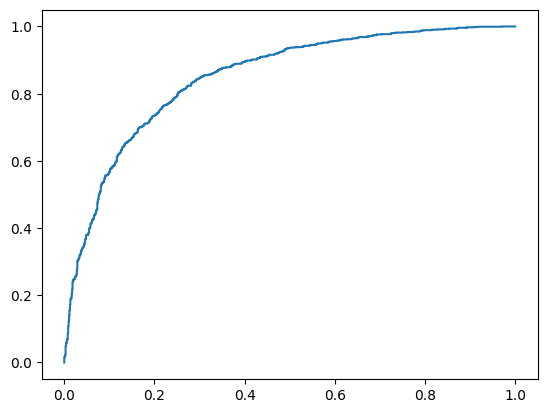

In [83]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

predictions = model.predict_proba(X_test)
fpr, tpr, thres = roc_curve( y_test, predictions[:, 1])
plt.plot( fpr, tpr )

roc_auc_score_value = roc_auc_score(y_test, predictions[:, 1])
print(f'Значение roc_auc_score = {roc_auc_score_value}')

## Реализация подсчета метрик TPR, FPR «вручную»

In [103]:
tp = 0 # True positive
fp = 0 # False positive
fn = 0 # False negative
tn = 0 # True negative

predictions = model.predict_proba( X_test )
for predicted_prob, actual in zip( predictions[:, 1], y_test ):    
    if predicted_prob >= 0.5:
        predicted = 1
    else:
        predicted = 0
    
    if predicted == 1:
        if actual == 1:
            tp += 1
        else:
            fp += 1
    
    else:
        if actual == 1:
            fn += 1
        else:
            tn += 1

result_accuracy_hands = (tp + tn) / (tp + fp + fn + tn)
result_accuracy_libs = model.score(X_test, y_test)
print(f'Результат ручного рассчета accuracy: {result_accuracy_hands}')
print(f'Результат библиотечного рассчета accuracy: {result_accuracy_libs}')

result_FPR_hands = fp / (fp + tn)
print(f'Результат ручного рассчета FPR: {result_FPR_hands}')

result_TPR_hands = tp / (tp + fn)
print(f'Результат ручного рассчета TPR: {result_TPR_hands}')

# Напишем сразу метод, который делает тоже самое для всех значений, а не только для 0.5
def manual_roc_curve(y_true, y_scores):
    # Преобразуем y_true в numpy array для корректного индексирования
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Сортируем вероятности по убыванию
    indices = np.argsort(y_scores)[::-1]
    y_scores_sorted = y_scores[indices]
    y_true_sorted = y_true[indices]
    
    # Уникальные пороги (вероятности + крайние значения)
    thresholds = np.unique(y_scores_sorted)
    thresholds = np.append(thresholds, 1.1)  # Добавляем порог выше максимума
    thresholds = np.append(-0.1, thresholds) # Добавляем порог ниже минимума
    thresholds = np.sort(thresholds)[::-1]   # Сортируем по убыванию
    
    tpr_list = []  # True Positive Rate
    fpr_list = []  # False Positive Rate
    
    # Рассчитываем TPR и FPR для каждого порога
    for threshold in thresholds:
        # Предсказания для текущего порога
        y_pred = (y_scores_sorted >= threshold).astype(int)
        
        # Расчет матрицы ошибок
        tp = np.sum((y_pred == 1) & (y_true_sorted == 1))
        fp = np.sum((y_pred == 1) & (y_true_sorted == 0))
        fn = np.sum((y_pred == 0) & (y_true_sorted == 1))
        tn = np.sum((y_pred == 0) & (y_true_sorted == 0))
        
        # Расчет TPR и FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return np.array(fpr_list), np.array(tpr_list)

fpr_manual, tpr_manual = manual_roc_curve(y_test, predictions[:, 1])

Результат ручного рассчета accuracy: 0.7785961871750433
Результат библиотечного рассчета accuracy: 0.7785961871750433
Результат ручного рассчета FPR: 0.26229508196721313
Результат ручного рассчета TPR: 0.8119590873328089


## Построим график ROC-кривой с полученными метриками

Text(0, 0.5, 'True Positive Rate')

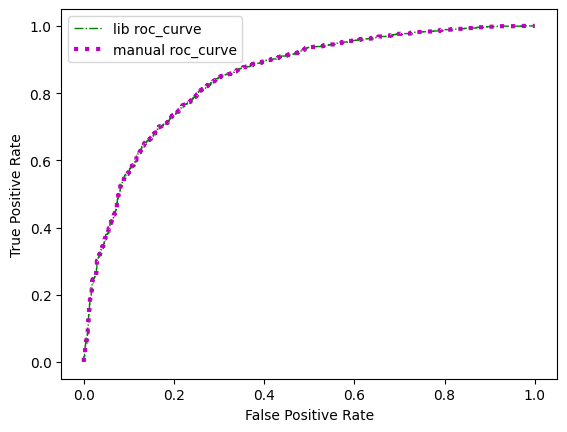

In [109]:
plt.plot( fpr, tpr, 'g-.', linewidth = 1, label = 'lib roc_curve')
plt.plot( fpr_manual, tpr_manual, 'm:', linewidth = 3, label = 'manual roc_curve')
plt.legend( loc = 0 )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Вывод:
Графики полностью совпадают

### График Precision-Recall и вычисление roc_auc_score

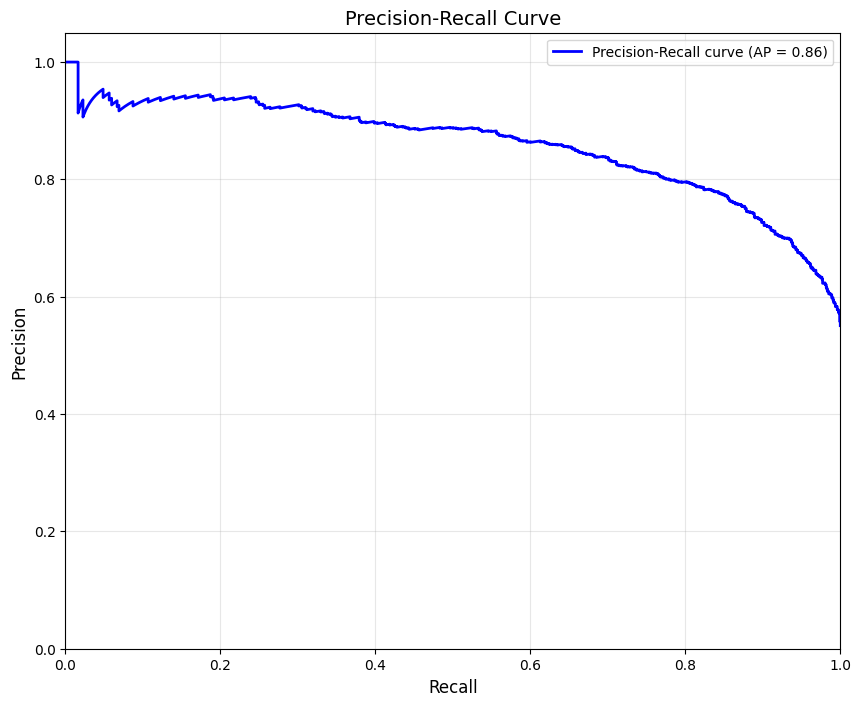

Значение roc_auc_score = 0.8486502932034017


In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Рассчитываем Precision-Recall метрики
precision, recall, thresholds = precision_recall_curve(y_test, predictions[:, 1])
average_precision = average_precision_score(y_test, predictions[:, 1])

# Строим график
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, 'b-', linewidth=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

roc_auc_score_value = roc_auc_score(y_test, predictions[:, 1])
print(f'Значение roc_auc_score = {roc_auc_score_value}')